Copyright (c) 2022 Graphcore Ltd. All rights reserved.

Inference using GPS++ on IPUs
==========

This notebook demonstrates doing inference on a single sample and the entire test-challenge dataset split using the model we used for our OGB-LSC PCQM4Mv2 submission.

We will use IPUs for this, which allows us to do inference on the entire test-challenge dataset split in less than a minute.

In the process of doing this we will see some of the additional features we generate from the original dataset and feed into the model.

Requirements:

* A Poplar SDK environment enabled (see the Getting Started guide for your IPU system or take a look at this projects README).
* Python packages installed with `pip install -r ../requirements.txt`

In [2]:
%pip install -q -r requirements.txt

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Note: you may need to restart the kernel to use updated packages.


This example requires building a few things:
* An optimised method to get the path lengths of a graph
* IPU optimised grouped gather scatter operaions

In [3]:
%%capture
! make -C data_utils/feature_generation
! make -C static_ops

In [2]:
%matplotlib inline

import os
import yaml
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

import tensorflow as tf
from argparser import parse_dict
from data_utils.load_dataset import CustomGraphData, load_raw_dataset
from data_utils.pcq_dataset_28features import smiles2graph_large, CustomPCQM4Mv2Dataset
from data_utils.preprocess_dataset import preprocess_dataset
from notebook_utils import predict

# Set the tensorflow log level 
tf.get_logger().setLevel("ERROR")

If running on Paperspace we will run some additional configuration steps below. If you aren't running on Paperspace, ensure you have the following environment variables set: `DATASET_DIR` - location of the dataset, `CHECKPOINT_DIR` - location of any checkpoints, `POPLAR_EXECUTABLE_CACHE_DIR` - location of any Poplar executable caches or update the paths manually in the below two cells.

In [6]:
if os.getenv("PAPERSPACE_METRIC_WORKLOAD_ID"):
    !mkdir -p /tmp/exe_cache
    !rm -rf /tmp/ogb_lsc_pcqm4mv2
    !cd /graphcore/ogb_lsc_pcqm4mv2/ && find -type d -exec mkdir -p "/tmp/ogb_lsc_pcqm4mv2/{}" \;
    !cd /graphcore/ogb_lsc_pcqm4mv2/ && find -type f -exec cp -sP "${PWD}/{}" "/tmp/ogb_lsc_pcqm4mv2/{}" \;
    os.environ["DATASET_DIR"] = "/tmp/ogb_lsc_pcqm4mv2/datasets/"
    os.environ["CHECKPOINT_DIR"] = "/tmp/ogb_lsc_pcqm4mv2/checkpoints"
    os.environ["POPLAR_EXECUTABLE_CACHE_DIR"] = "/tmp/ogb_lsc_pcqm4mv2/executables"

checkpoint_directory = os.environ.get("CHECKPOINT_DIR", ".")
dataset_directory = os.environ.get("DATASET_DIR", ".")

Lets also set a few things to enable us to use the executable caches, saving us from compiling the model.

In [7]:
executable_cache_dir = os.environ.get("POPLAR_EXECUTABLE_CACHE_DIR", ".")
os.environ["TF_POPLAR_FLAGS"] = f"--executable_cache_path='{executable_cache_dir}'"

### Loading a configuration

There are 3 configurations available with the model sizes of 11M (GPS_4layer), 22M (GPS_8layer) and 44M (GPS_16layer).
By choosing the model name, the corresponding config path and checkpoint path will be used.


In [62]:
# Choose model
model_name = "GPS_4layer" # choose from ["GPS_4layer", "GPS_8layer", "GPS_16layer"]

# Set configs
model_dict = {"GPS_4layer": "GPS_PCQ_4gps_11M.yaml", 
              "GPS_8layer": "GPS_PCQ_8gps_22M.yaml",
              "GPS_16layer": "GPS_PCQ_16gps_44M.yaml"}
cfg_path = Path("configs").joinpath(model_dict[model_name])
cfg_yaml = yaml.safe_load(cfg_path.read_text())
cfg = parse_dict(cfg_yaml)

# Set the checkpoint path for the corresponding config
sub_directory = model_dict[model_name].split(".")[0]
checkpoint_path = Path(checkpoint_directory).joinpath(f"{sub_directory}/model-FINAL")

# Turn off dataset caching for this notebook
cfg.dataset.save_to_cache = False
cfg.dataset.load_from_cache = False

### Predicting the HOMO-LUMO gap of a single molecule

The competition requires predicting the HOMO-LUMO energy gap of a number of molecules. To demonstrate inference of our model on the IPU we will start by predicting the HOMO-LUMO gap of a single molecule.

Lets create a smile string:

In [63]:
smile_string = "CC(NCC[C@H]([C@@H]1CCC(=CC1)C)C)C"

To get an idea of how this molecule looks lets visualise this smile string using [rdkit](https://www.rdkit.org/docs/GettingStartedInPython.html).

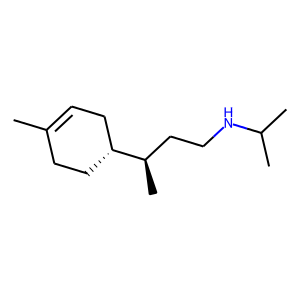

In [64]:
mol = Chem.MolFromSmiles(smile_string)
AllChem.Compute2DCoords(mol)
Draw.MolToImage(mol)

We now convert the smile string into some features our model can understand. The competition provides a method to do this (`smiles2graph`). We have written a custom version of this that uses [rdkit](https://www.rdkit.org/docs/GettingStartedInPython.html) to generate more features from the smile string.

In [65]:
graph_obj = smiles2graph_large(smile_string)

We can take a look at the features that have been created that represent this molecule.

In [66]:
graph_obj.keys()

dict_keys(['edge_index', 'edge_feat', 'node_feat', 'num_nodes'])

We can see the features that have been created:
* `edge_index` - The sending and receiving node indices, representing the edges in the graph.
* `edge_feat` - The features of each of the edges in the graph.
* `node_feat` - The features of each of the nodes in the graph.
* `num_nodes` - Number of nodes in the graph.

One thing to note is the size of the node features. They have a size of 28 compared to 9 that the OGB-LSC provided `smiles2graph` function creates.

In [67]:
len(graph_obj["node_feat"][0])

28

Now we will wrap this single graph in our dataset wrapper, which contains some metadata and the dataset object itself.

In [68]:
graphs = [graph_obj]
graph_raw = CustomGraphData(graphs,
                            use_extended_features=True,
                            use_conformers=True,
                            trim_chemical_features=cfg.dataset.trim_chemical_features,
                            use_periods_and_groups=cfg.dataset.use_periods_and_groups,
                            do_not_use_atomic_number=cfg.dataset.do_not_use_atomic_number,
                            chemical_node_features=cfg.dataset.chemical_node_features,
                            chemical_edge_features=cfg.dataset.chemical_edge_features)

Getting stats for test-challenge split: 100%|██████████| 1/1 [00:00<00:00, 16384.00it/s]


Now lets feed this through our dataset preprocessing pipeline.

In [69]:
graph_preprocessed = preprocess_dataset(dataset=graph_raw, options=cfg)

Generating atom_distance features...: 100%|██████████| 1/1 [00:00<00:00, 1091.13it/s]


Lets take a look at the additional features created.

In [70]:
preprocessed_single_graph = graph_preprocessed.dataset[0][0]
preprocessed_single_graph.keys()

dict_keys(['edge_index', 'edge_feat', 'node_feat', 'num_nodes', 'ogb_conformer', 'senders', 'receivers', 'ogb_bond_lengths', 'nan_in_conformer', 'lap_eig_vals', 'lap_eig_vecs', 'random_walk_landing_probs', 'node_graph_idx', 'edge_graph_idx', 'shortest_path_distances', 'centrality_encoding', 'atom_distances', 'direction_vector'])

You can see we now have many more features. Ones of note are:

* `lap_eig_vals` - The laplacian eigenvalues used as positional encodings in the model.
* `lap_eig_vecs` - The laplacian eigenvectors used as positional encodings in the model.
* `random_walk_landing_probs` - The random walk feature used as structural encodings in the model.
* `shortest_path_distances` - The shortest path distances (2D graph structure information) used as attention bias.
* `centrality_encoding` - Degrees of the atoms.
* `ogb_conformer`, `ogb_bond_lengths` and `atom_distances` require the 3D position information which is only provided for training data. You will see these values are NaNs or zeros for our inference case.

Checking the size of the node features you will see that is smaller than before. From the 28 features we had before we have selected 11, based on how beneficial the features were for training. For example, we found the features related to the atomic number group, period and family to be very beneficial.

In [71]:
len(preprocessed_single_graph["node_feat"][0])

11

Now we are ready to run on the IPU. We have wrapped this functionality in a single function for simplicity. We encourage you to check the contents of this function.

The first time running the model in inference on IPUs will require the model to be compiled. This can take a few minutes. We have cached the executable so any subsequent runs we want to do will not require this compile phase.

Now lets predict the HOMO-LUMO gap of the molecule.

In [72]:
prediction, _ = predict(graph_preprocessed, checkpoint_path, "test-challenge", cfg)

Creating input specification...
Configuring the IPUs...
Creating TensorFlow dataset from preprocessed dataset...


100%|██████████| 1/1 [00:00<00:00, 13706.88it/s]


Constructing the model...


Loading the checkpoint from /localdata/adams/checkpoints_tarballs/GPS_PCQ_4gps_11M/model-FINAL...
Running `model.predict` to generate predictions...


/a/scratch/kerstink/research/envs/ogb-lsc_POD/lib/python3.6/site-packages/keras/engine/functional.py:589: UserWarning: Input dict contained keys ['node_mask', 'edge_mask'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


In [73]:
prediction[0]

6.76

### Predictions on the validation dataset split

Doing a single prediction at a time is very inefficient. In this next section we will generate predictions for the entire `valid` dataset split, which on IPU is very fast.

In [34]:
cases = ("valid", )
split_mode = "original"

Now lets load and preprocess the dataset. These steps are the same as those we took when preprocessing the single molecule, but does the preprocessing only on the molecules in the `valid` dataset split. This will be done from scratch so can take a few minutes.

In [39]:
graph_data = load_raw_dataset(cfg.dataset.dataset_name,
                              dataset_directory,
                              cfg,
                              split=cases,
                              load_ensemble_cache=True,
                              split_mode=split_mode,
                              ensemble=True)
graph_data = preprocess_dataset(dataset=graph_data,
                                options=cfg,
                                load_ensemble_cache=False,
                                folds=cases,
                                split_mode=split_mode,
                                ensemble=True)

Generating atom_distance features...: 100%|██████████| 3746620/3746620 [00:20<00:00, 179938.63it/s]


Now lets get predictions on the entire `valid` dataset split.

In [36]:
predictions, ground_truth = predict(graph_data, checkpoint_path, cases[0], cfg)

Creating input specification...
Configuring the IPUs...
Creating TensorFlow dataset from preprocessed dataset...


100%|██████████| 73545/73545 [00:04<00:00, 16706.73it/s]


Constructing the model...
Loading the checkpoint from /localdata/adams/ogb_lsc_pcqm4mv2/checkpoints/GPS_PCQ_4gps_11M/model-FINAL...
Running `model.predict` to generate predictions...


Lets take a look at the mean, variance and histogram of the predictions and histogram of the ground truth labels.

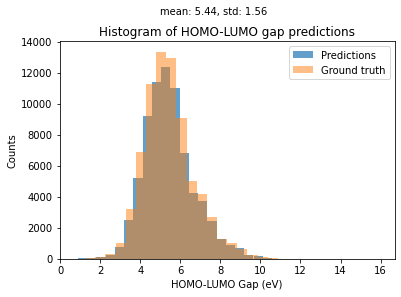

In [37]:
mean = predictions.astype(float).mean()
std = predictions.astype(float).var()

plt.hist(predictions, 30, alpha = 0.7, label = 'Predictions')
plt.hist(ground_truth, 30, alpha = 0.5, label = 'Ground truth')
plt.xlabel("HOMO-LUMO Gap (eV)")
plt.ylabel("Counts")
plt.title("Histogram of HOMO-LUMO gap predictions")
plt.legend()
plt.text(5, 15000, f'mean: {mean:.2f}, std: {std:.2f} \n')
plt.show()

We could compare the predicted values with the true labels and calculate the MAE (Mean Absolute Error) as below. The model we test here is a small one (11M parameters). To achieve a better MAE we could select one of the larger models (22M or 44M) and re-run the predictions. For the challenge submission we ran the largest model (44M) with 16 GPS layers.

In [38]:
mean_MAE = np.mean(np.abs(np.array(predictions) - np.array(ground_truth)))
mean_MAE

0.08999300505693687

Lets have a look at some molecules with their corresponding label and prediction. First, we have to load the raw data...

In [22]:
# Load raw SMILES strings with corresponding label and select only validation molecules
smiles_only = CustomPCQM4Mv2Dataset(root = './', only_smiles=True)
valid_idx=smiles_only.get_idx_split()['valid']
valid_smiles=[]
for i in valid_idx:
    valid_smiles.append(smiles_only[i])

Now we can plot random molecules in the `valid` dataset

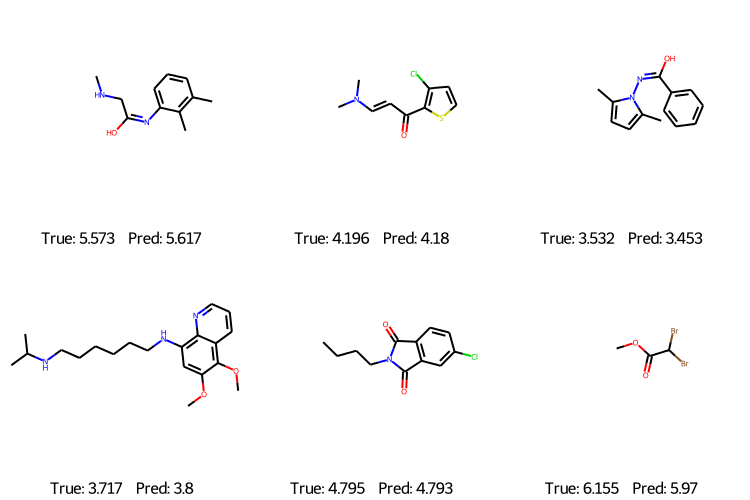

In [23]:
# Choose 6 random indices from validation dataset
r_idx = random.sample(range(len(valid_smiles)), 6)
# Extract SMILES, RDKit molecular objects, ground_truth labels, and predictions for these molecules
Smiles = [valid_smiles[r][0] for r in r_idx]
GT = [valid_smiles[r][1] for r in r_idx]
Mols = [Chem.MolFromSmiles(r) for r in Smiles]
Pred = [predictions[r] for r in r_idx]

# Create labels
labelList = ["True: " + str('%.3f' %gt) +  "\v Pred: " + str(prediction) for gt, prediction in zip(GT,Pred)]
# Display molecules with labels
Draw.MolsToGridImage(Mols,molsPerRow=3,legends=[label for label in labelList],
                    subImgSize=(250,250), useSVG=False)


Lets now look at the mean absolute error compared to a global molecular property such as number of nodes.

First, we have to extract the number of nodes from our graph data...

In [24]:
num_nodes_list = []
for i in valid_idx:
    num_nodes_list.append(graph_data.dataset[i][0]['num_nodes'])
    

For simplicity we create a dataframe with columns ground truth, prediction, and number of nodes

In [25]:
df = pd.DataFrame(list(zip(ground_truth, predictions,num_nodes_list)), columns=['ground_truth','prediction','num_nodes'])
df.head()

,ground_truth,prediction,num_nodes
0,4.587840,5.558594,17
1,4.971520,5.558594,17
2,5.496700,5.519531,15
3,5.485815,5.519531,15
4,4.748387,4.761719,14


Now, lets plot the mean HOMO-LUMO gap and mean prediction per molecule size... 

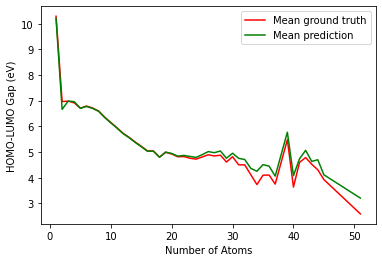

In [26]:
# plotting a line graph
plt.plot(df.groupby("num_nodes")['ground_truth'].mean(),color='red', label = 'Mean ground truth')
plt.plot(df.groupby("num_nodes")['prediction'].mean(),color='green', label = 'Mean prediction')
plt.legend()
plt.ylabel("HOMO-LUMO Gap (eV)")
plt.xlabel("Number of Atoms")
plt.show()

Now, lets add the mean absolute error to our dataframe and compare it to the molecule size...

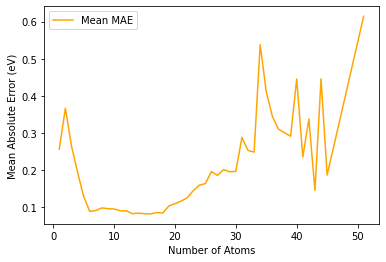

In [27]:
# Add MAE to dataframe
df['mae']= np.abs(df["ground_truth"]-df["prediction"])
# plot
plt.plot(df.groupby("num_nodes")['mae'].mean(),color='orange', label = 'Mean MAE')
plt.legend()
plt.ylabel("Mean Absolute Error (eV)")
plt.xlabel("Number of Atoms")
plt.show()


It seems that our model struggles to predict the HOMO-LUMO gap for larger molecules. However, there are only very few molecules (31 in total) that consist of 40 or more atoms. Therefore, lets see how much molecules of a particular size contribute to the overall error

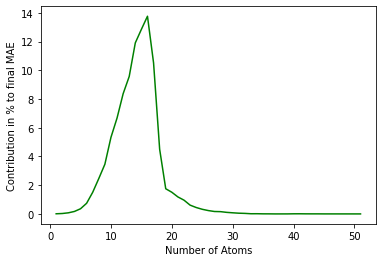

In [28]:
# Add MAE to dataframe
df['mae']= np.abs(df["ground_truth"]-df["prediction"])
# plot
plt.plot(df.groupby("num_nodes")['mae'].size()/73545*100,color='green')
plt.ylabel("Contribution in % to final MAE")
plt.xlabel("Number of Atoms")
plt.show()


### Follow up tasks

* Try changing the smile string and seeing what HOMO-LUMO gap is predicted.
* Try a larger model (`GPS_PCQ_8gps_22M.yaml` or `GPS_PCQ_16gps_44M.yaml`) and the corresponding checkpoint.
* Take a look at the `predict` function to get an understanding of what is required to run on IPUs.
* Use the 'test-challenge' split of the dataset to predict HOMO-LUMO gaps for the molecules in the challenge.